In [44]:
import numpy as np
import scipy.integrate
import scipy.interpolate
%matplotlib inline
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.lines as mlines
import glob
import operator as op

from __future__ import print_function, division

mpl.rc('font', size=18)
mpl.rc('figure', figsize=(12,6))
mpl.rc('figure', autolayout=False)
mpl.rc('text', usetex=False)

In [37]:
# convert a string representation of a number
# of the sort produced by spherical_cloudy
# back into a numerical value, by replacing:
#     'd' with '.'
#     'p' with '+'
#     'n' with '-'
def deformat_string(s):
    return s.replace('d', '.').replace('p', '+').replace('m', '-')

ions = ['H I', 'D I', 'He I', 'He II']
nions = len(ions)

sph_cloudy_dtype = ([('rad', 'float64'),           # radius
                     ('temp', 'float64'),          # temperature
                     ('pres', 'float64'),          # pressure
                     ('hden', 'float64'),          # HI volume density
                     ('HaSB', 'float64'),          # surface brightness in H-alpha
                     ('vden', 'float64', nions),   # volume density for each species
                     ('cden', 'float64', nions)])  # column density for each species

class SphCloudyResult:
    def __init__(self, fname):
        self.fname = fname
        self.data = np.load(fname)
        self.data.dtype = sph_cloudy_dtype
        
        # parse the file name to extract model parameters
        self.params = dict()
        end_of_rel_path = fname.rfind('/') + 1
        fname_parts = fname[end_of_rel_path:].split('_')
        for part in fname_parts:
            if(part == 'NFW'):
                self.params['profile'] = 'NFW'
            elif part.startswith('mass'):
                mass_str = deformat_string(part[4:])
                self.params['mass'] = float(mass_str)
            elif part.startswith('redshift'):
                z_str = deformat_string(part[8:])
                self.params['redshift'] = float(z_str)
            elif part.startswith('baryscl'):
                bary_str = deformat_string(part[7:])
                self.params['bary_scl'] = float(bary_str)
            elif part.startswith('HMscale'):
                He_str = deformat_string(part[7:])
                self.params['HM_scl'] = float(He_str)
            else:
                # remaining part is nrad_nmu (.npy)
                nrad, nmu = (part.rstrip('.npy').split('-'))
                self.params['n_rad'] = nrad
                self.params['nmu'] = nmu

In [45]:
sph_cloudy_files = glob.glob('./data/NFW*.npy')
sph_cloudy_data = [SphCloudyResult(f) for f in sph_cloudy_files]

def compose(f, g):
    return lambda x: f(g(x))

sorted_by_mass = sorted(sph_cloudy_data, key=compose(op.itemgetter('mass'),op.attrgetter('params')))
sph_cloudy_masses = np.array(list(map(compose(op.itemgetter('mass'),op.attrgetter('params')), sorted_by_mass)))
sph_cloudy_radii = np.array([res.data['rad'] for res in sorted_by_mass]).squeeze()
sph_cloudy_lognh = np.log10([res.data['hden'] for res in sorted_by_mass]).squeeze()
sph_cloudy_temps = np.log10([res.data['temp'] for res in sorted_by_mass]).squeeze()

In [39]:

cm_per_kpc = 3e10 * 86400 * 365 * 3.26 * 1000
mp = 1.673e-24

# Masses and radii are the same for Eagle/Prada models
my_masses = np.loadtxt('rhos_gas_eagle_masses.dat')

nhaloes = len(my_masses)

R200s = np.loadtxt('rhos_gas_eagle_Rvirs.dat').flatten()
my_radii, _ = np.hsplit(np.loadtxt('rhos_gas_eagle.dat'), [1])
my_radii = (my_radii[:,np.newaxis] * R200s / cm_per_kpc).squeeze().transpose()

# Eagle
_, my_lognh_eagle, my_temps_eagle = np.hsplit(np.loadtxt('rhos_gas_eagle.dat'), [1, 1 + nhaloes])
my_lognh_eagle = np.log10(my_lognh_eagle / mp).transpose()
my_temps_eagle =my_temps_eagle.transpose()

# Prada
_, my_lognh_prada, my_temps_prada = np.hsplit(np.loadtxt('rhos_gas_prada.dat'), [1, 1 + nhaloes])
my_lognh_prada = np.log10(my_lognh_prada / mp).transpose()
my_temps_prada = my_temps_prada.transpose()

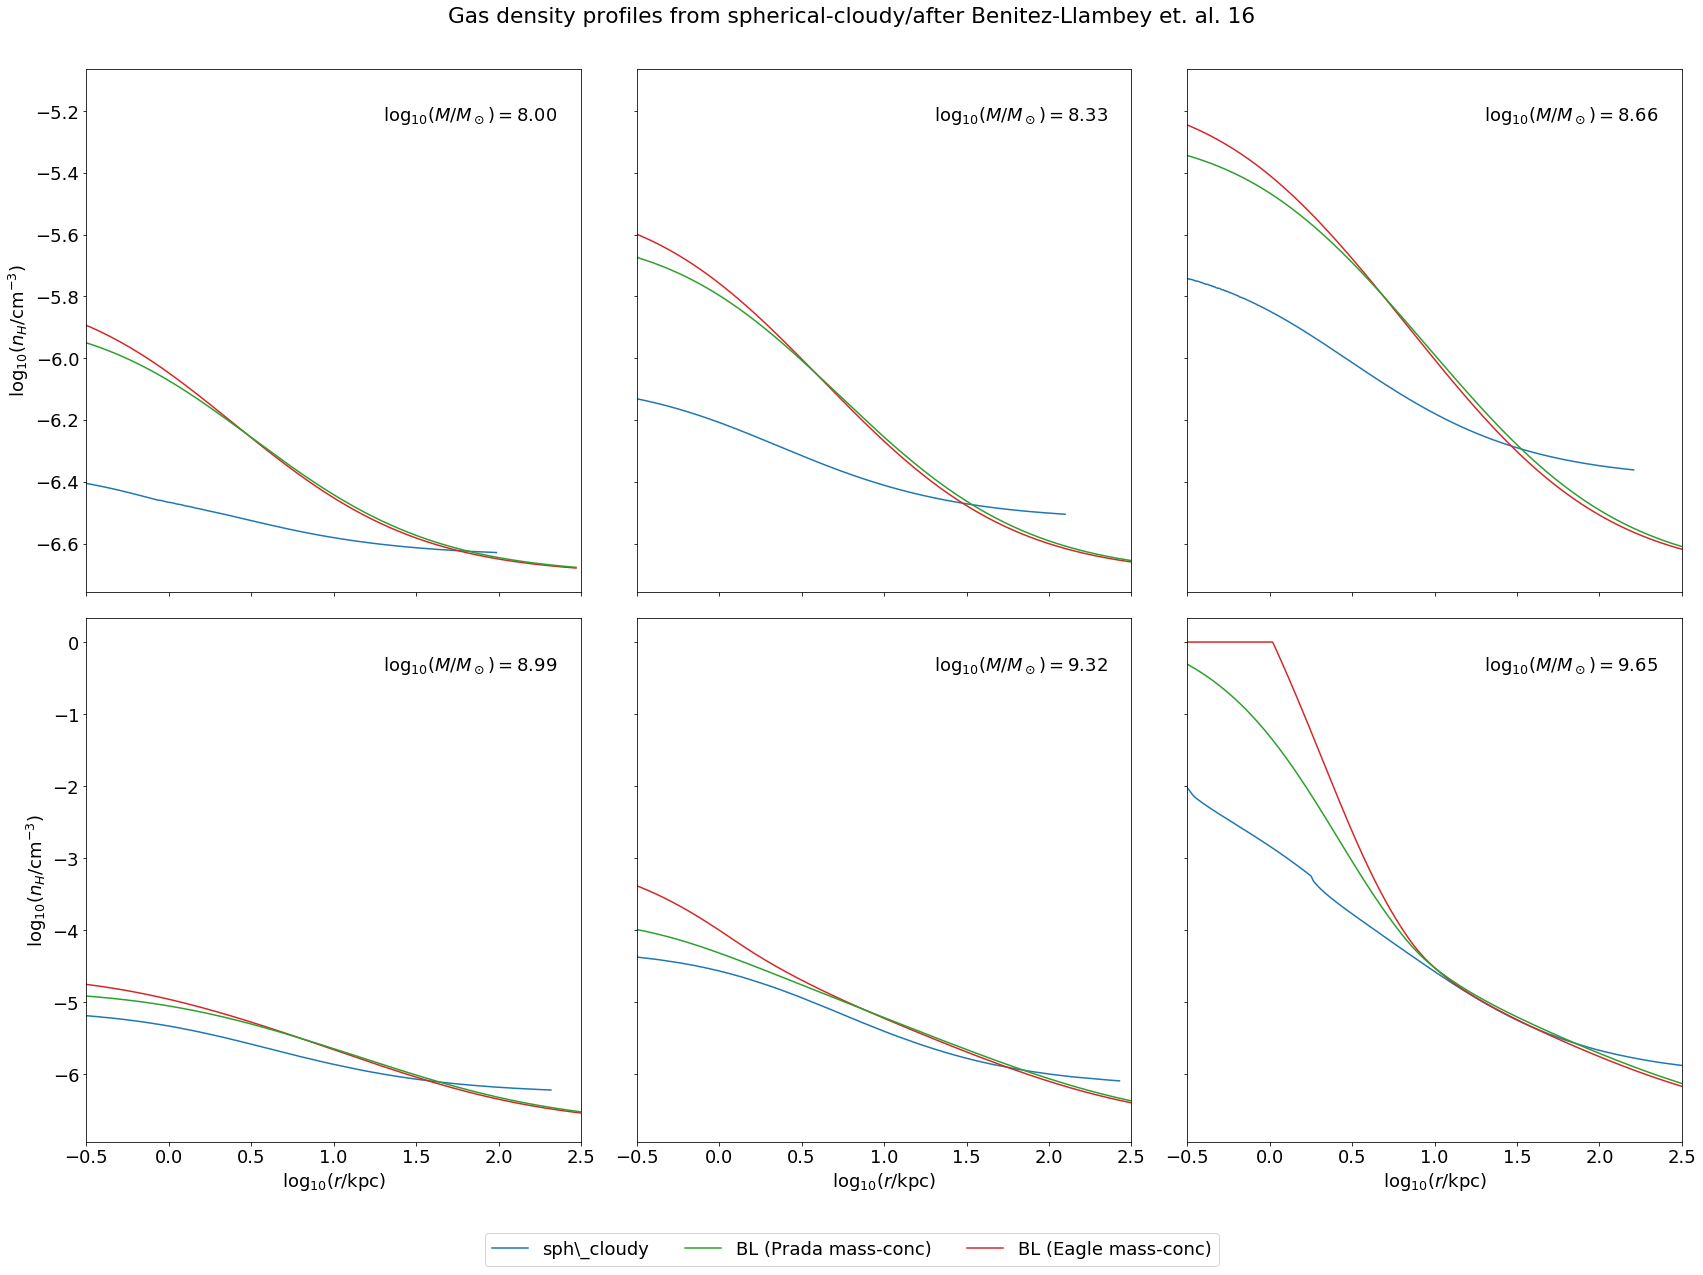

In [22]:
idx = [0, 4, 8, 12, 16, 20]

fig, axs = plt.subplots(2, 3, figsize=(24, 18), sharex=True, sharey='row')
fig.suptitle('Gas density profiles from spherical-cloudy/after Benitez-Llambey et. al. 16')
for i, ax in zip(idx, axs.flat):    
    ax.set_xlim(-.5, 2.5)
    ax.set_xlabel(r'$\log_{10}(r/\mathrm{kpc})$')
    ax.set_ylabel(r'$\log_{10}(n_H/\mathrm{cm}^{-3})$')
    ax.label_outer()
    ax.plot(np.log10(sph_cloudy_radii[i,1:] / 1000), sph_cloudy_lognh[i,1:], c='tab:blue')
    ax.plot(np.log10(my_radii[i]), my_lognh_eagle[i], c='tab:red')
    ax.plot(np.log10(my_radii[i]), my_lognh_prada[i], c='tab:green')
    ax.annotate(s=r'$\log_{{10}}(M/M_\odot)={:.2f}$'.format(np.log10(my_masses[i])), xy=(0.6, 0.9), xycoords='axes fraction') 
lines = [mlines.Line2D([], [], c='tab:blue'), mlines.Line2D([], [], c='tab:green'), mlines.Line2D([], [], c='tab:red')]
labels = ['sph\_cloudy', 'BL (Prada mass-conc)', 'BL (Eagle mass-conc)']
fig.legend(lines, labels, ncol=3, loc='lower center')
fig.tight_layout(rect=[0,0.05,1,0.95])
#fig.savefig('dp_compare.pdf', bbox_inches='tight')

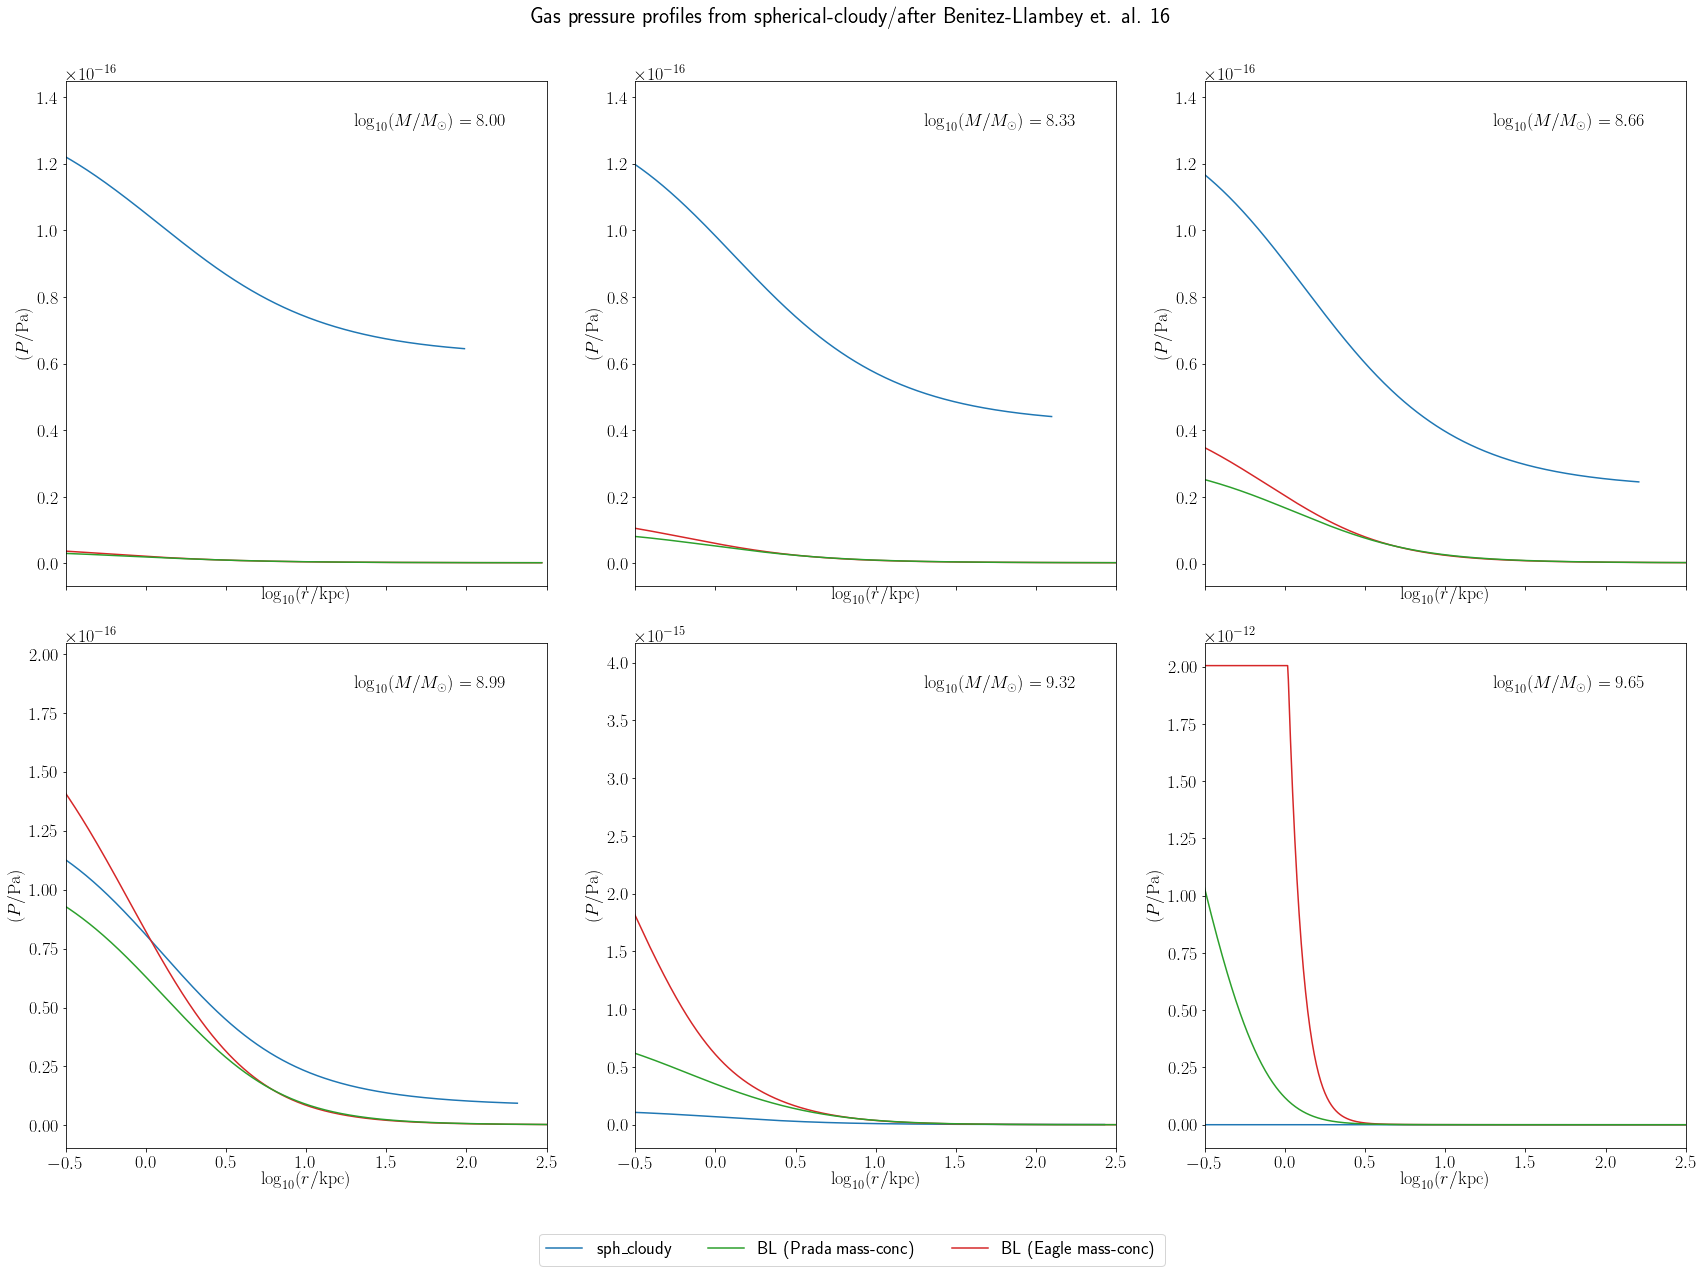

In [43]:
sph_cloudy_pressure = np.array([res.data['pres'] for res in sorted_by_mass]).squeeze()

idx = [0, 4, 8, 12, 16, 20]

kB = 1.3807e-16
mu = 0.6
mp = 1.673e-24

def my_P(lognh, T):
    return 10**lognh * kB * T / mu

fig, axs = plt.subplots(2, 3, figsize=(24, 18), sharex=True, sharey=False)
fig.suptitle('Gas pressure profiles from spherical-cloudy/after Benitez-Llambey et. al. 16')
for i, ax in zip(idx, axs.flat):    
    ax.set_xlim(-.5, 2.5)
    ax.set_xlabel(r'$\log_{10}(r/\mathrm{kpc})$')
    ax.set_ylabel(r'$(P/\mathrm{Pa})$')
    #ax.label_outer()
    ax.plot(np.log10(sph_cloudy_radii[i,1:] / 1000), sph_cloudy_pressure[i,1:]*kB, c='tab:blue')
    ax.plot(np.log10(my_radii[i]), my_P(my_lognh_eagle[i], my_temps_eagle[i]), c='tab:red')
    ax.plot(np.log10(my_radii[i]), my_P(my_lognh_prada[i], my_temps_prada[i]), c='tab:green')
    ax.annotate(s=r'$\log_{{10}}(M/M_\odot)={:.2f}$'.format(np.log10(my_masses[i])), xy=(0.6, 0.9), xycoords='axes fraction') 
lines = [mlines.Line2D([], [], c='tab:blue'), mlines.Line2D([], [], c='tab:green'), mlines.Line2D([], [], c='tab:red')]
labels = ['sph\_cloudy', 'BL (Prada mass-conc)', 'BL (Eagle mass-conc)']
fig.legend(lines, labels, ncol=3, loc='lower center')
fig.tight_layout(rect=[0,0.05,1,0.95])
fig.savefig('p_compare.pdf', bbox_inches='tight')

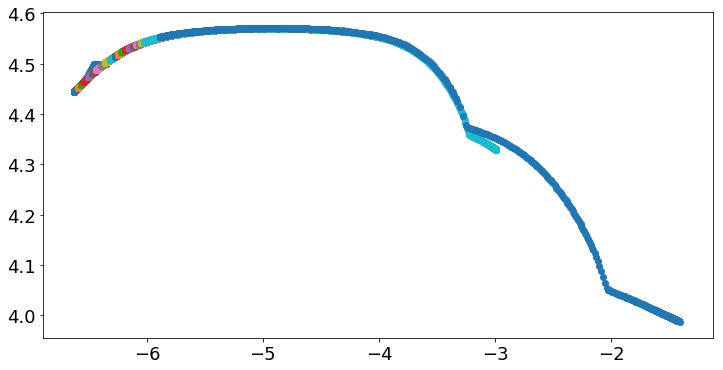

In [51]:
plt.figure()
[plt.scatter(sph_cloudy_lognh[idx], sph_cloudy_temps[idx]) for idx in range(21)];
